In [ ]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pydicom as dicom
from os import listdir
from glob import glob
import plotly.express as px
import cv2 as cv
import math

## Load in dataset labels 

In [ ]:
data_folder = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"

In [ ]:
!ls -la /kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification

In [ ]:
df_labels = pd.read_csv(f"{data_folder}/train_labels.csv")
df_labels.head()

> **The target variable MGMT_value for each subject in the training data indicates the presence of MGMT promoter methylation.** 

In [ ]:
print(f"Dataset shape: {df_labels.shape}")
df_labels.groupby('MGMT_value').size().reset_index(name='counts')

In [ ]:
sns.countplot(x = 'MGMT_value',data =df_labels)
plt.show()

> **Dataste is banalanced to some extent**

## Load in the train data

```
Training/Validation/Testing
│
└─── 00000
│   │
│   └─── FLAIR
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1wCE
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T2w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ .....

```


### Attributes of Data 

In [ ]:
train_data_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'
patients = os.listdir(train_data_path)
patients.sort()
df_labels['patient_id'] = patients

In [ ]:
# Create a list of .dicom files

patient_scan_files = [] 
for dir_name, subdir_list, file_list in os.walk(train_data_path):
    for file_name in file_list:
        if ".dcm" in file_name.lower():
            patient_scan_files.append(os.path.join(dir_name,file_name))
            
patient_scan_files.sort()

print(f"Number of patients: {len(patients)}")
print("Number of (.dicom) files =", len(patient_scan_files))

In [ ]:
# Read a single dicom files
ds = dicom.dcmread(patient_scan_files[6])
print(f"Size of dicom file: {ds.pixel_array.shape}")
plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

Input size is too big for convolutional network to handle, using opencv to resize it

Let's read one patient record and resize it

In [ ]:
IMG_PX_SIZE = 150

for patient in patients[6:7]:
    print(f"Patient Id: {patient}")
    label = df_labels._get_value(df_labels[df_labels['patient_id'] == str(patient)].index.tolist()[0], 
                                 'MGMT_value')
    print(f"MGMT promoter methylation present: {True if label == 1 else False}\n")
    path = train_data_path + '/' + patient 
    
    # For every patient record there are 4 different types of scans available 
    patient_scan_types = os.listdir(path)
    for scan_type in patient_scan_types:
        dicom_path = path + '/' + scan_type +'/*.dcm'
        dicom_files = sorted(glob(dicom_path),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
        slices = [dicom.read_file(file)for file in dicom_files]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        print(f"Scan Type:{scan_type}, {len(slices)}, {slices[0].pixel_array.shape}")
        fig = plt.figure()
        mid = len(slices)//2
        for num, dicom_slice in enumerate(slices[mid-4:mid+4]):
            y = fig.add_subplot(3,4,num+1)
            img = cv.resize(np.array(dicom_slice.pixel_array),(IMG_PX_SIZE, IMG_PX_SIZE))
            plt.imshow(img)
        plt.show()
        

### Preprocessing

There are three problems that needs to addressed 

1. Input size of the dicom files need to reduced currently it is 512X512 
    - This can be achieved using opencv as shown above
    
2. Slices for each scan type is different 
    - One way to get same number of slices for the scan is chunck the list of slices based on predefined NUM_SLICES then average all the chunks to get single chunk. 
    
    
3. Scan color contrast need to be retained 

In [ ]:
# generator function to extract chunks from the list of slices 
def chunks(dicom_file_list, number_chunks):
    for i in range(0, len(dicom_file_list), number_chunks):
        yield dicom_file_list[i:i+number_chunks]
        
def mean(dicom_file_list):
    return sum(dicom_file_list)/len(dicom_file_list)

In [ ]:
IMG_PX_SIZE = 150
NUM_SLICES = 10

def preprocess_data(patient, scan_type, df_labels, img_px_size=150, num_slices=10, visualize=False):
    label = df_labels._get_value(df_labels[df_labels['patient_id'] == str(patient)].index.tolist()[0], 
                                 'MGMT_value')
    dicom_path = train_data_path + '/' + patient +'/'+ scan_type +'/*.dcm'
    dicom_files = sorted(glob(dicom_path),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
    slices = [dicom.read_file(file)for file in dicom_files]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    # Resize the all the slices
    slices = [cv.resize(np.array(each_slice.pixel_array),(img_px_size, img_px_size)) for each_slice in slices]

    # Determine the size of the chunks
    chunk_size = math.ceil(len(slices) / num_slices)


    for slice_chunk in chunks(slices, chunk_size):
        chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(chunk)

    # Handle uneven chunks 
    new_slices_size = len(new_slices)

    if (new_slices_size != num_slices):
        if (new_slices_size < num_slices):
            for _ in range(num_slices-new_slices_size):
                new_slices.append(new_slices[-1])
        elif(new_slices_size > num_slices):
            missing_slices = new_slices_size - num_slices
            for _ in range(missing_slices):
                val = list(map(mean, zip(*[new_slices[num_slices-1], new_slices[num_slices]])))
                del new_slices[num_slices]
                new_slices[num_slices -1] = val
                    
    if visualize:
        fig = plt.figure()
        for num, dicom_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            plt.imshow(dicom_slice, cmap='gray')
        plt.show()
                    
    if label == 1: label = np.array([0,1])
    elif label == 0: label = np.array([1,0])
    
    return np.array(new_slices), label

In [ ]:
master_data = []

for i, patient in enumerate(patients):
    if i%100 == 0:
            print(f"Processed {i} patients")
    for scan_type in patient_scan_types:
        try:
            img_data , label = preprocess_data(patient,
                                               scan_type,
                                               df_labels, 
                                               img_px_size=IMG_PX_SIZE, 
                                               num_slices=NUM_SLICES, 
                                               visualize=False)
            master_data.append([img_data, label])
        except Exception as e:
            print(str(e))
            print(f"Unabled to preprrocess the {i} patient scans")
        
np.save('masterdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, NUM_SLICES), master_data)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tfv1

IMG_SIZE_PX = 150
SLICE_COUNT = 10

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [ ]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [ ]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([8871936,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, NUM_SLICES, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 8871936])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [ ]:
master_data = np.load('./masterdata-150-150-20.npy', allow_pickle=True)
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = master_data[:-100]
validation_data = master_data[-100:]


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tfv1.reduce_mean( tfv1.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)
        
# train_neural_network(x)

## Scan Analysis

MR scanner can generate three types of orientations of human brain.
1. Axial - from top to down
2. Coronal - from front to back
3. Sagittal - and side to side

In the X-Y-Z coordinate system, 
- A axial is an X-Y plane, parallel to the ground, the head from the feet. 
- A coronal is an X-Z plane, the front from the back. 
- A sagittal is a Y-Z plane, which separates left from right

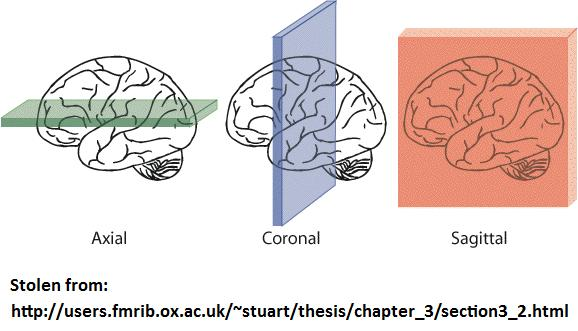

In [ ]:
# helper methods 

def read_dcm(path):
    return dicom.dcmread(path)

def read_dcm_by_seq(cohort, patient_id, mri_sequence):
    files_glob = f'{data_folder}/{cohort}/{patient_id}/{mri_sequence}/*.dcm'
    sorted_files = sorted(glob(files_glob),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
    return [dicom.read_file(f) for f in sorted_files]

def display_dcm(dicom):
    plt.imshow(dicom.pixel_array)
    plt.show()
    
def display_full_scan(dicom_instance_list):
    images = np.array([dcm.pixel_array for dcm in dicom_instance_list])
    fig = px.imshow(images, 
                    animation_frame=0, 
                    binary_string=True, 
                    labels=dict(animation_frame="instance"), 
                    height=600)
    fig.show()
    

In [ ]:
# Extract Scan orientation information

def scan_orientation(dcm):
    rt = None
    (x1, y1, z1, x2, y2, z2) = [round(cord) for cord in dcm.ImageOrientationPatient]
    if (x1,y1,x2,y2) == (1,0,0,0):
        rt = 'coronal'
    if (x1,y1,x2,y2) == (1,0,0,1):
        rt = 'axial'
    if (x1,y1,x2,y2) == (0,1,0,0):
        rt = 'sagittal'
        
    if (rt):
        return rt
    else:
        raise ValueError(f"Failed extract the Scan Orientation")

The most common MRI sequences are T1-weighted and T2-weighted scans. (https://case.edu/med/neurology/NR/MRI%20Basics.htm)

- T1-weighted images are produced by using short TE and TR times. The contrast and brightness of the image are predominately determined by T1 properties of tissue. Conversely, 

- T2-weighted images are produced by using longer TE and TR times. In these images, the contrast and brightness are predominately determined by the T2 properties of tissue.

- A third commonly used sequence is the Fluid Attenuated Inversion Recovery (Flair). The Flair sequence is similar to a T2-weighted image except that the TE and TR times are very long

- T1WCE is another sequence in which contrast is enhanced. 

These sequences results in different contrast of Gray scale in the scans 

**Dataset has scan taken for all these MRI sequence techniques.** 

Let's fetch one Patient  data and analze it

In [ ]:
cohort = 'train'
patient_id  = '00000'

### Load all the dicom files as per thier sequence of MRI for the given Patient ID

In [ ]:
flair_data_files = read_dcm_by_seq(cohort, patient_id, 'FLAIR')
t1w_data_files = read_dcm_by_seq(cohort, patient_id, 'T1w')
t1wce_data_files = read_dcm_by_seq(cohort, patient_id, 'T1wCE')
t2w_data_files = read_dcm_by_seq(cohort, patient_id, 'T2w')

### Orientations of the scans for each sequence type

In [ ]:
print(f"Scan Orientation of MRI Sequences,  Total Number of Instances \n")

print(f"FailR: {scan_orientation(flair_data_files[0])}, Instances: {len(flair_data_files)} \n")

print(f"T1w: {scan_orientation(t1w_data_files[0])}, Instances: {len(t1w_data_files)}\n")

print(f"T1wce: {scan_orientation(t1wce_data_files[0])}, Instances: {len(t1wce_data_files)}\n")

print(f"T2w: {scan_orientation(t2w_data_files[0])}, Instances: {len(t2w_data_files)}\n")

### Visualize the full MRI scans**

*1. Flair*

In [ ]:
display_full_scan(flair_data_files)

*2. T1w*

In [ ]:
display_full_scan(t1w_data_files)

*3. T1wc*

In [ ]:
display_full_scan(t1wce_data_files)

*4. T2w*

In [ ]:
display_full_scan(t2w_data_files)

**Start and end of the scan has a lot of empty frames which needs to removed in preprocessing**